# Prelude

In [ ]:
import os
if not os.path.isdir('src'):
    %cd ..

In [2]:
import gpytorch
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from src.pep import PowerEPGP

# Define dataset

In [3]:
np.random.seed(42);
torch.manual_seed(42);

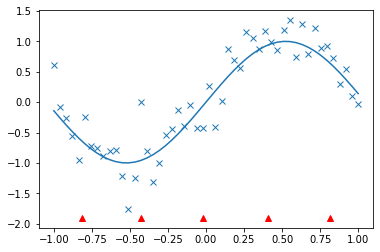

In [13]:
n = 50
m = 5
X = torch.linspace(-1, 1, n).view(-1, 1)
y = torch.sin(X * 3).view(-1) + 0.34 * torch.randn(n)

import sklearn.cluster

# noinspection PyUnresolvedReferences
kmeans = sklearn.cluster.KMeans(n_clusters=m)
kmeans.fit(X)
Z = torch.from_numpy(kmeans.cluster_centers_).to(X)

plt.plot(X, y, 'x')
plt.plot(X, torch.sin(X * 3), 'C0-')
plt.plot(Z, np.ones_like(Z) * plt.ylim()[0], 'r^');

# Train GPyTorch SVGP

In [5]:
class GPyTorchSVGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, pseudo_inputs):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super(GPyTorchSVGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.InducingPointKernel(
            self.base_covar_module,
            inducing_points=pseudo_inputs,
            likelihood=likelihood
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


pytorch_svgp = GPyTorchSVGP(X, y, Z)

pytorch_svgp.train()
optimizer = torch.optim.Adam(pytorch_svgp.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(pytorch_svgp.likelihood, pytorch_svgp)

train_steps = 500
for i in range(train_steps):
    optimizer.zero_grad()
    output = pytorch_svgp(X)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()

In [6]:
pytorch_svgp.covar_module.base_kernel.outputscale += 1e-6

gpytorch\models\exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


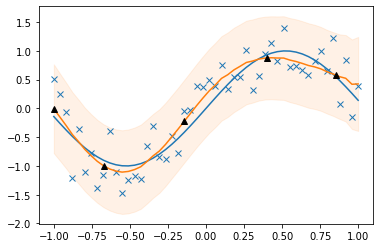

In [7]:
pytorch_svgp.eval()
with torch.no_grad():
    plt.plot(X, y, 'C0x')
    plt.plot(X, torch.sin(X * 3), 'C0-')
    y_pred = pytorch_svgp.likelihood(pytorch_svgp(X))
    l, u = y_pred.confidence_region()
    plt.plot(X, y_pred.mean, 'C1-')
    plt.fill_between(X[:, 0], l, u, color='C1', alpha=0.1)
    plt.plot(pytorch_svgp.covar_module.inducing_points, pytorch_svgp(pytorch_svgp.covar_module.inducing_points).mean,
             'k^')

# Power EP

In [8]:
# noinspection PyShadowingNames,PyPep8Naming
def iterate_pep():
    """Do one dataset pass of EP and save how far the parameters are"""
    param_movement = []
    with torch.no_grad():
        Ku = pep_gp.kernel(pep_gp.inducing_points)
        chol_Ku = Ku.cholesky().evaluate()
        Ku = Ku.evaluate()
        Kf = pep_gp.kernel(pep_gp.train_x).diag()
        Kfu = pep_gp.kernel(pep_gp.train_x, pep_gp.inducing_points).evaluate()
        KuKuf = torch.cholesky_solve(Kfu.T, chol_Ku)

    for i in range(len(pep_gp.train_x)):
        vi_updated, gi_updated, gamma_updated, beta_updated = pep_gp.single_step(
            pep_gp.train_y[i], Kf[i], Kfu[[i]], KuKuf[:, [i]],
            pep_gp.v[i], pep_gp.g[i]
        )
        with torch.no_grad():
            pep_gp.v[i] = vi_updated
            pep_gp.g[i] = gi_updated
            pep_gp.gamma = gamma_updated
            pep_gp.beta = beta_updated
            param_movement.append({
                'i': i,
                # Distance from last parameters
                'd_g': (old_gi - pep_gp.g).numpy(),
                'd_v': (old_vi - pep_gp.v).numpy(),
                'd_gamma': (old_gamma - pep_gp.gamma).numpy(),
                'd_beta': (old_beta - pep_gp.beta).numpy(),
                # Distance from fixpoint distribution
                'qu_mean': (q_u.loc - (Ku @ pep_gp.gamma).view(-1)).numpy(),
                'tu_mean': (t_u.g - pep_gp.g).numpy(),
                'tu_var': (t_u.v - pep_gp.v).numpy(),
            })
    return param_movement

In [ ]:
pep_gp = PowerEPGP(
    X, y,
    pytorch_svgp.covar_module, pytorch_svgp.likelihood,
    alpha=0.1, inf=1e10
)

with torch.no_grad():
    Ku = pep_gp.kernel(pep_gp.inducing_points)
    chol_Ku = Ku.cholesky().evaluate()
    Ku = Ku.evaluate()
    
    q_u = pep_gp.exact_q_u()
    t_u = pep_gp.exact_t_u()

## Initialize with fixpoint distribution

In [10]:
with torch.no_grad():
    pep_gp.g = t_u.g.clone()
    pep_gp.v = t_u.v.clone()
    pep_gp.gamma = torch.cholesky_solve(q_u.loc[:, None], chol_Ku)
    pep_gp.beta = torch.cholesky_solve(
        torch.cholesky_solve(Ku - q_u.covariance_matrix, chol_Ku).T,
        chol_Ku
    )

## Iterate EP

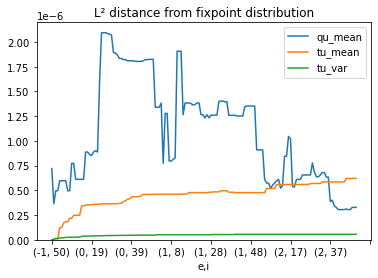

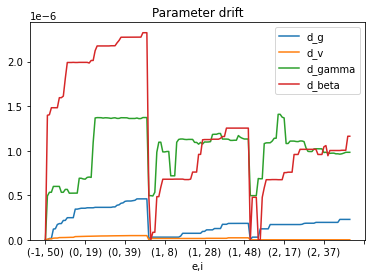

In [11]:
with torch.no_grad():
    param_movement = [{
        'e': -1, # Which pass of the dataset
        'i': len(pep_gp.train_x), # Data point index
        # Distance from last parameters
        'd_g': np.zeros(pep_gp.g.shape),
        'd_v': np.zeros(pep_gp.v.shape),
        'd_gamma': np.zeros(pep_gp.gamma.shape),
        'd_beta': np.zeros(pep_gp.beta.shape),
        # Distance from fixpoint distribution
        'qu_mean': (q_u.loc - (Ku @ pep_gp.gamma).view(-1)).numpy(),
        'tu_mean': (t_u.g - pep_gp.g).numpy(),
        'tu_var': (t_u.v - pep_gp.v).numpy(),
    }]

# Three EP full dataset passes
for e in range(3):
    old_gi = pep_gp.g.clone()
    old_vi = pep_gp.v.clone()
    old_gamma = pep_gp.gamma.clone()
    old_beta = pep_gp.beta.clone()

    param_movement.extend(
        {**x, 'e': e}
        for x in iterate_pep()
    )
    with torch.no_grad():
        param_movement.append({
            'e': e,
            'i': len(pep_gp.train_x),
            'd_g': (old_gi - pep_gp.g).numpy(),
            'd_v': (old_vi - pep_gp.v).numpy(),
            'd_gamma': (old_gamma - pep_gp.gamma).numpy(),
            'd_beta': (old_beta - pep_gp.beta).numpy(),
            'qu_mean': (q_u.loc - (Ku @ pep_gp.gamma).view(-1)).numpy(),
            'tu_mean': (t_u.g - pep_gp.g).numpy(),
            'tu_var': (t_u.v - pep_gp.v).numpy(),
        })
delta_norm = pd.DataFrame([
    {
        k: np.linalg.norm(v) if k not in ('e', 'i') else v
        for k, v in p.items()
    }
    for p in param_movement
]).set_index(['e', 'i']).astype(float)

delta_norm[['qu_mean', 'tu_mean', 'tu_var']].plot()
plt.title('L² distance from fixpoint distribution')
plt.ylim(0, 1 if plt.ylim()[1] > 1 else plt.ylim()[1]);

delta_norm[['d_g', 'd_v', 'd_gamma', 'd_beta']].plot()
plt.title('Parameter drift')
plt.ylim(0, 1 if plt.ylim()[1] > 1 else plt.ylim()[1]);

# Compare SVGP with EP

gpytorch\models\exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


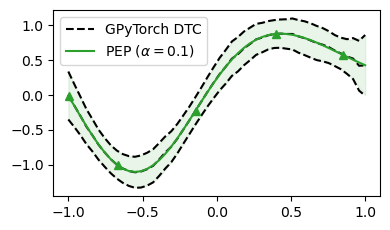

In [14]:
pytorch_svgp.eval()
q_u_ep = pep_gp.posterior_u()
q_f_ep = pep_gp.posterior_f(jitter=1e-6)

q_f = pytorch_svgp(X)

f, ax = plt.subplots(1, 1, tight_layout=True, figsize=np.array((5, 3)) * 0.8, dpi=100)
with torch.no_grad():
    l, u = q_f.confidence_region()
    plt.plot(X[:, 0], q_f.mean, '--k', label='GPyTorch DTC')
    plt.plot(X[:, 0], l, '--k')
    plt.plot(X[:, 0], u, '--k')

    l, u = q_f_ep.confidence_region()
    plt.plot(X, q_f_ep.mean, 'C2-', label=f'PEP $(\\alpha = {pep_gp.alpha})$')
    plt.fill_between(X[:, 0], l, u, color='C2', alpha=0.1)
    plt.plot(pytorch_svgp.covar_module.inducing_points, q_u_ep.loc, 'C2^')
plt.legend();